# Intro

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model, impute
import lightgbm as lgb
color = sns.color_palette()
%matplotlib inline

In [2]:
train_features = pd.read_pickle('catfeatures_train.pkl',compression='zip')
test_features = pd.read_pickle('catfeatures_test.pkl',compression='zip')

In [4]:
print(train_features.shape)
print(test_features.shape)

(1503424, 256)
(508438, 256)


In [7]:
train = pd.read_pickle('train.pkl',compression='zip')
test = pd.read_pickle('test.pkl',compression='zip')

In [101]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_features', 3149673384),
 ('test_features', 1065177714),
 ('new_features', 24054888),
 ('Pipeline', 1056),
 ('color', 176),
 ('miss_vars', 88),
 ('ensemble', 80),
 ('feature_selection', 80),
 ('impute', 80),
 ('lgb', 80),
 ('linear_model', 80),
 ('metrics', 80),
 ('model_selection', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('preprocessing', 80),
 ('sns', 80),
 ('imputer', 56),
 ('indicator', 56)]

# Other Features

## Day of Week

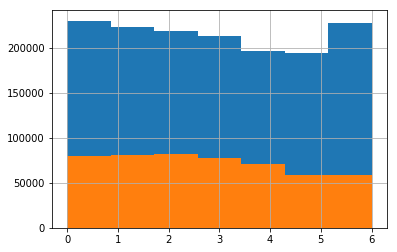

In [9]:
train.activation_date.dt.weekday.hist(bins=7)
test.activation_date.dt.weekday.hist(bins=7)
plt.show()

In [6]:
# Add day features to train
new_features = pd.DataFrame(index=train.index)

new_features = new_features.join(pd.get_dummies(train["activation_date"].dt.weekday))

new_features.columns =['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

new_features.head()

train_features = train_features.join(new_features)

In [7]:
# Add day features to test
new_features = pd.DataFrame(index=test.index)

new_features = new_features.join(pd.get_dummies(test["activation_date"].dt.weekday))

new_features.columns =['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

test_features = test_features.join(new_features)

In [8]:
print(train_features.shape)
print(test_features.shape)

(1503424, 263)
(508438, 263)


## Missing Values

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 11 columns):
item_id             1503424 non-null object
user_id             1503424 non-null object
title               1503424 non-null object
description         1387148 non-null object
price               1418062 non-null float64
item_seq_number     1503424 non-null int64
activation_date     1503424 non-null datetime64[ns]
user_type           1503424 non-null object
image               1390836 non-null object
image_top_1         1390836 non-null float64
deal_probability    1503424 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 126.2+ MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508438 entries, 0 to 508437
Data columns (total 10 columns):
item_id            508438 non-null object
user_id            508438 non-null object
title              508438 non-null object
description        508438 non-null object
price              477853 non-null float64
item_seq_number    508438 non-null int64
activation_date    508438 non-null datetime64[ns]
user_type          508438 non-null object
image              465829 non-null object
image_top_1        465829 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 38.8+ MB


- Test data has no missing values in description.

In [10]:
indicator = impute.MissingIndicator(missing_values=True,error_on_new=False)

indicator.fit(test.isna())

miss_vars = ['price_miss','image_miss','image_top_1_miss']

new_features = pd.DataFrame(indicator.transform(train.drop('deal_probability',axis=1).isna()),columns=miss_vars)
print('As bool:')
print(new_features.sum())
display(new_features.head())

new_features = new_features.astype(int)
print('\nAs int:')
print(new_features.sum())
display(new_features.head())

As bool:
price_miss           85362
image_miss          112588
image_top_1_miss    112588
dtype: int64


,price_miss,image_miss,image_top_1_miss
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False



As int:
price_miss           85362
image_miss          112588
image_top_1_miss    112588
dtype: int64


,price_miss,image_miss,image_top_1_miss
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [11]:
train_features = train_features.join(new_features)

In [12]:
new_features = pd.DataFrame(indicator.transform(test.isna()),columns=miss_vars)
new_features = new_features.astype(int)
test_features = test_features.join(new_features)

In [13]:
print(train_features.shape)
print(test_features.shape)

(1503424, 266)
(508438, 266)


## Word Lengths
### Description & Title

In [14]:
new_features = pd.DataFrame(index=train.index)

new_features['desc_words'] = train.description.fillna('').apply(lambda x: len(x.split()))

train_features = train_features.join(new_features)

In [15]:
new_features = pd.DataFrame(index=test.index)

new_features['desc_words'] = test.description.fillna('').apply(lambda x: len(x.split()))

test_features = test_features.join(new_features)

In [16]:
print(train_features.shape)
print(test_features.shape)

(1503424, 267)
(508438, 267)


In [17]:
new_features = pd.DataFrame(index=train.index)

new_features['title_words'] = train.title.fillna('').apply(lambda x: len(x.split()))

train_features = train_features.join(new_features)

In [18]:
new_features = pd.DataFrame(index=test.index)

new_features['title_words'] = test.title.fillna('').apply(lambda x: len(x.split()))

test_features = test_features.join(new_features)

In [19]:
print(train_features.shape)
print(test_features.shape)

(1503424, 268)
(508438, 268)


## Imputations
### Price, Image_top_1

In [55]:
print('PRICE\n')
print('Train Median:',np.median(train.price.dropna()))
print('Test Median:',np.median(test.price.dropna()))
print("")
print('Train Mean:',np.mean(train.price.dropna()))
print('Test Mean:',np.mean(test.price.dropna()))

PRICE

Train Median: 1300.0
Test Median: 1500.0

Train Mean: 316708.0884982462
Test Mean: 279818.9459415343


In [58]:
train.price.describe()

count    1.418062e+06
mean     3.167081e+05
std      6.689154e+07
min      0.000000e+00
25%      5.000000e+02
50%      1.300000e+03
75%      7.000000e+03
max      7.950101e+10
Name: price, dtype: float64

In [62]:
print('Image_Top_1\n')
print('Train Median:',np.median(train.image_top_1.dropna()))
print('Test Median:',np.median(test.image_top_1.dropna()))
print("")
print('Train Mean:',np.mean(train.image_top_1.dropna()))
print('Test Mean:',np.mean(test.image_top_1.dropna()))

Image_Top_1

Train Median: 1057.0
Test Median: 1132.0

Train Mean: 1241.9321192433904
Test Mean: 1297.959227527698


In [63]:
train.image_top_1.describe()

count    1.390836e+06
mean     1.241932e+03
std      9.704641e+02
min      0.000000e+00
25%      4.250000e+02
50%      1.057000e+03
75%      2.217000e+03
max      3.066000e+03
Name: image_top_1, dtype: float64

In [20]:
imputer = impute.SimpleImputer(strategy='median')

imputer.fit(train[['price','image_top_1']].append(test[['price','image_top_1']]))

new_features = pd.DataFrame(imputer.transform(train[['price','image_top_1']]))

new_features.columns = ['price_imp','image_top_1_imp']

train_features = train_features.join(new_features)

In [21]:
new_features = pd.DataFrame(imputer.transform(test[['price','image_top_1']]))

new_features.columns = ['price_imp','image_top_1_imp']

test_features = test_features.join(new_features)

In [22]:
print(train_features.shape)
print(test_features.shape)

(1503424, 270)
(508438, 270)


### Item_Seq_Number

In [93]:
train.item_seq_number.describe()

count    1.503424e+06
mean     7.436740e+02
std      5.572522e+03
min      1.000000e+00
25%      9.000000e+00
50%      2.900000e+01
75%      8.800000e+01
max      2.044290e+05
Name: item_seq_number, dtype: float64

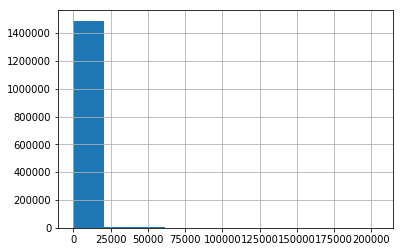

In [94]:
train.item_seq_number.hist()

In [23]:
train_features['seq_n'] = train['item_seq_number']

In [24]:
test_features['seq_n'] = test['item_seq_number']

In [25]:
print(train_features.shape)
print(test_features.shape)

(1503424, 271)
(508438, 271)


---

In [2]:
train_features.to_pickle('train_features.pkl',compression='zip')
test_features.to_pickle('test_features.pkl',compression='zip')

NameError: name 'train_features' is not defined

```python
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")
```

# Score with Current Features

In [3]:
train_features = pd.read_pickle('train_features.pkl',compression='zip')
test_features = pd.read_pickle('test_features.pkl',compression='zip')

In [4]:
print(train_features.shape)
print(test_features.shape)

(1503424, 271)
(508438, 271)


In [5]:
scaler = preprocessing.StandardScaler()

train_features = pd.DataFrame(scaler.fit_transform(train_features),columns=train_features.columns)

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
model = linear_model.LinearRegression()
cv = model_selection.cross_val_score(model,train_features,train.deal_probability,cv=3)
score = np.mean(cv)
print('Score with current features:',score)

Score with current features: 0.17661872011553495


In [9]:
model.fit(train_features,train.deal_probability)

coefs = pd.DataFrame()

coefs['feature'] = train_features.columns.tolist()

coefs['coef'] = model.coef_

coefs['absolute'] = np.absolute(coefs['coef'])

In [10]:
model.score(train_features,train.deal_probability)

0.17944587633587636

In [11]:
coefs.sort_values(by='absolute',ascending=False)

,feature,coef,absolute
241,Predlozhenie uslug,1.996018e+11,1.996018e+11
211,Uslugi,-1.996018e+11,1.996018e+11
206,Dlja doma i dachi,-1.237389e+11,1.237389e+11
254,Private,9.635575e+10,9.635575e+10
253,Company,9.000867e+10,9.000867e+10
231,Mebel' i inter'er,7.776137e+10,7.776137e+10
245,Remont i stroitel'stvo,7.250900e+10,7.250900e+10
215,Bytovaja tehnika,5.658698e+10,5.658698e+10
255,Shop,4.806865e+10,4.806865e+10
240,Posuda i tovary dlja kuhni,2.960910e+10,2.960910e+10


### Analyzing SelectFromModel

- I wonder if this 'absolute' ranking is the same that `SelectFromModel` would use to filter features.

In [30]:
selector = feature_selection.SelectFromModel(model,max_features=10,prefit=True)

best_selector = train_features.columns[selector.get_support()].tolist()

best_absolute = coefs.sort_values(by='absolute',ascending=False).iloc[:10,0].tolist()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 271 but corresponding boolean dimension is 13

In [26]:
[f in best_selector for f in best_absolute]

[True, True, True, True, True, True, True, True, True, True, True, True, True]

In [27]:
[f in best_absolute for f in best_selector]

[True, True, True, True, True, True, True, True, True, True, True, True, True]

- They are the same, in different orders.
- Now let's get a score.

In [29]:
best_selector = train_features.loc[:,selector.get_support()]

model.fit(best_selector,train.deal_probability)
model.score(best_selector,train.deal_probability)

0.06697919090197546

- Much below the 271 features.

# LightGBM

In [31]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [35]:
# Splitting the data for model training#
dev_X = train_features.iloc[:-200000,:]
val_X = train_features.iloc[-200000:,:]
dev_y = train.deal_probability[:-200000]
val_y = train.deal_probability[-200000:]

# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_features)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.235903
[40]	valid_0's rmse: 0.232932
[60]	valid_0's rmse: 0.231725
[80]	valid_0's rmse: 0.230966
[100]	valid_0's rmse: 0.230399
[120]	valid_0's rmse: 0.230028
[140]	valid_0's rmse: 0.229749
[160]	valid_0's rmse: 0.229512
[180]	valid_0's rmse: 0.229321
[200]	valid_0's rmse: 0.229172
[220]	valid_0's rmse: 0.229035
[240]	valid_0's rmse: 0.228882
[260]	valid_0's rmse: 0.228777
[280]	valid_0's rmse: 0.228681
[300]	valid_0's rmse: 0.228593
[320]	valid_0's rmse: 0.228506
[340]	valid_0's rmse: 0.228439
[360]	valid_0's rmse: 0.228381
[380]	valid_0's rmse: 0.228329
[400]	valid_0's rmse: 0.228266
[420]	valid_0's rmse: 0.228223
[440]	valid_0's rmse: 0.228181
[460]	valid_0's rmse: 0.228132
[480]	valid_0's rmse: 0.228082
[500]	valid_0's rmse: 0.228036
[520]	valid_0's rmse: 0.228008
[540]	valid_0's rmse: 0.227969
[560]	valid_0's rmse: 0.227948
[580]	valid_0's rmse: 0.227919
[600]	valid_0's rmse: 0.227878
[620]	valid

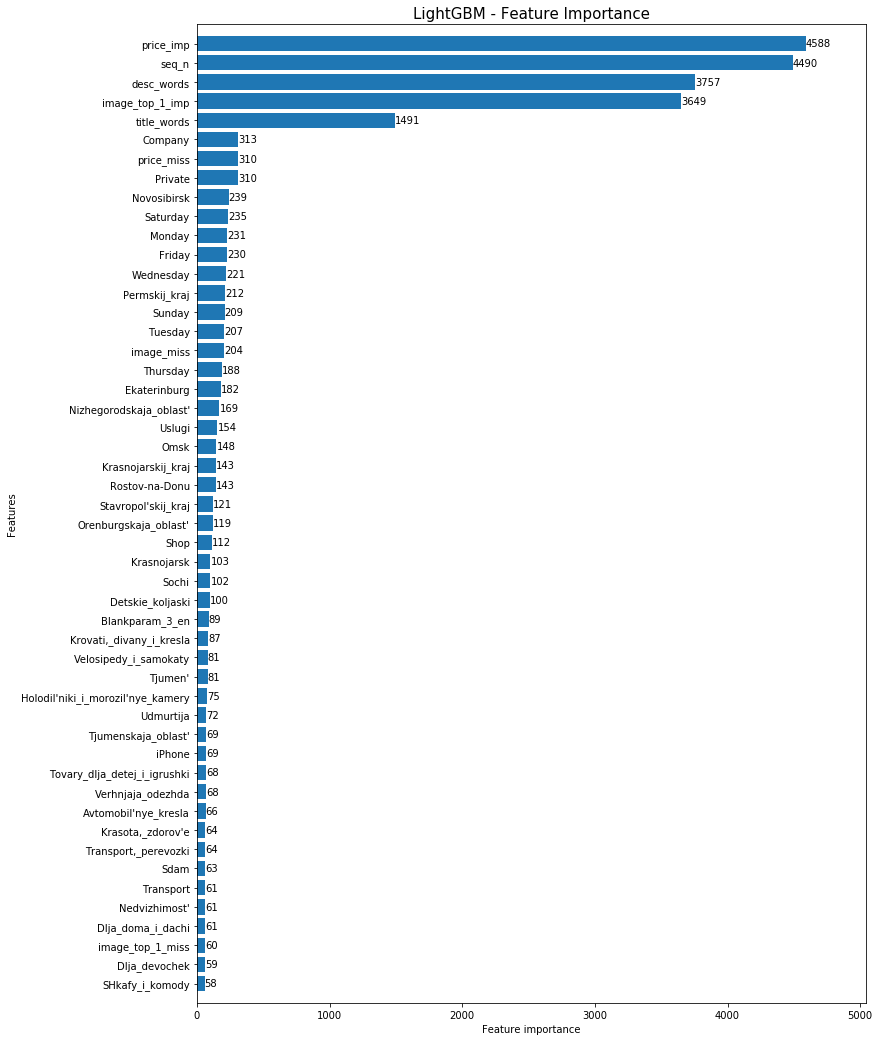

In [36]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()